In [45]:
#Библиотеки для работы с данными
import numpy as np
import pandas as pd
#Для построения и работы с графиками
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#Для работы с моделями
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#Для оценки результатов обучения модели
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, classification_report
#Контроль над скоростью обучения
from keras.callbacks import ReduceLROnPlateau
#Для работы с изображениями
import cv2
from PIL import Image
#Для взаимодействия с ОС
import os

In [2]:
#Подтянем директории с файлами для обучения
#Тренировочная часть
train_dir = './data/emotion_recog_data/train'
#Публичная тестовая часть датасета
test_dir = './data/emotion_recog_data/test'

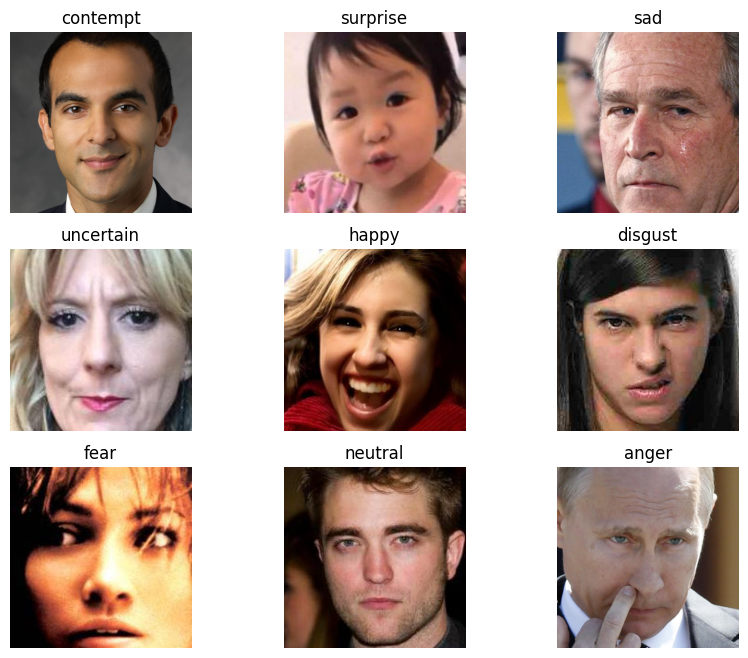

In [3]:
#Выведщем по одному изображения каждой эмоции
fig = plt.figure(figsize=(10, 8)) 
#Определим к-во столбцов и строк для отображения фотографий:
rows = 3
columns = 3

emo_cnt = 0
for dir_ in os.listdir(train_dir):#для каждой папки/эмоции
    emo_cnt+=1
    fig.add_subplot(rows, columns, emo_cnt) #добавим изображение эмоции на график
    im = Image.open(os.path.join(train_dir, dir_, '9.jpg'))
    emo_img = np.asarray(im)
    plt.imshow(emo_img) 
    plt.axis('off') 
    plt.title(dir_)

In [4]:
# Похоже, что изображения имеют разный размер. Проверим это на практике.
sizes = [] #пустой список для сбора размеров

# Проходимся по всем директориям папки с тренировочными изображениями
for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')): #проверка того, что файл является изображением
            # Пропишем путь к файлу
            file_path = os.path.join(dirpath, filename)
            # Загрузим изображение
            img = Image.open(file_path)
            # Сохраним его параметры в список
            sizes.append(img.size)
            
#Теперь посчитаем к-во изображений каждого размера
s_count = pd.Series(sizes).value_counts()

In [5]:
#Выведем, что получилось
s_count.head(10)

(256, 256)    294
(186, 186)    283
(183, 183)    283
(188, 188)    276
(192, 192)    267
(193, 193)    265
(196, 196)    260
(203, 203)    259
(179, 179)    256
(197, 197)    250
Name: count, dtype: int64

**Выводы:** 
1) Размер у изображений, как заметно выше, совершенно разный при сходной форме (все фотографии были обрезаны до квадрата). С этим, в принципе, можно работать при условии приведения всех изображений к одному размеру для подачи в модель.
2) Не все изображения эмоций являются репрезентативными:
* есть картинки с посторонними предметами и объектами, закрывающими в какой-то степени лицо; 
* присутствуют в выборке изображения низкого качества (слишком темные и размытые);
* в связи с общей сложностью задачи определения эмоций для обычного человека, присутствуют также фотографии, на которых эмоция не совсем однозначна и трудно интерпретируема. 

*Примечание: номер изображения для вывода выше подбирала, чтобы этих недочетов было как можно меньше. Как мне кажется, на этих фотографиях лица более-менее четкие и эмоции соответствуют проставленному ярлыку.*

In [6]:
# Проходимся по всем директориям папки с тренировочными изображениями
for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')): #проверка того, что файл является изображением
            # Пропишем путь к файлу
            file_path = os.path.join(dirpath, filename)
            # Загрузим изображение
            img = Image.open(file_path)
            # Сохраним его параметры в список
            sizes.append(img.size)
#Теперь посчитаем к-во изображений каждого размера
s_count = pd.Series(sizes).value_counts()

In [7]:
#Посмотрим также на распределение количества изображений по категориям (эмоциям)

cat_list = []
count_list = []
for dir_ in os.listdir(train_dir):
    count = 0
    for f in os.listdir(train_dir+ "/" + dir_ + "/"):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):#отберём только изображения
            count += 1
    cat_list.append(dir_)
    count_list.append(count)
#     print(f"{dir_} has {count} number of images")
counts_df = pd.DataFrame({'emotion': cat_list,
     'images_count': count_list
    })
counts_df.sort_values(by=['emotion'], inplace = True)

In [8]:
#Всего изображений:
sum(counts_df['images_count'])

50047

Настроим параметры отображения графика и выведем его на экран:

In [9]:
CLASS_LABELS_EMOJIS = ["😠", "😕" , "🤢","😨" , "😊" , "😐 ", "☹️" , "😲","🤔" ]

In [10]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = counts_df['images_count'] , 
             color = counts_df['emotion'],
             #определим цвета для каждой эмоции
             color_discrete_map={
                'anger': 'firebrick',
                'contempt': 'darkmagenta',
                'disgust':'olivedrab',
                'fear':'dimgray',
                'happy':'gold',
                'neutral':'lightblue',
                'sad':'navy',
                'surprise':'mediumvioletred',
                'uncertain':'tan'
            },
             template='presentation') 
fig.update_xaxes(title="Emotions")
fig.update_xaxes(tickfont_size =20)
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True, legend_title_text='Named emotions',
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
               
)
fig.show()

**Вывод:** Больше всего в нашем сете изображений сердитых лиц, на втором и третьем местах - нейтральные и грустные лица. Меньше всего изображений с лицами, изображающими презрение и отвращение. Это означает, что обученная на этих данных модель скорее всего будет лучше выявлять такие эмоции, как злость и печаль, а с теми, что на последних местах, справится хуже.

Теперь можно заняться подготовкой данных для подачи в модель. Сделаем это с помощью класса ImageDataGenerator.

Через него зададим следующие параметры предобработки и преоразования изображений для подачи в модель:

* horizontal_flip - случайное отражение по горизонтали
* rotation_range - максимальный угол поворота
* width_shift_range - смещение ширины по горизонтали до заданного процента
* height_shift_range - смещение высоты изображения по вертикали до заданного процента
* zoom_range - картинка будет увеличена или уменьшена не более чем на заданный процент
* rescale - масштабирование изображения, в нашем случае 1/255, т.е. до значений в пределах от 0 до 1 (упрощает модели работу)
* validation_split  - выделим долю картинок для валидации
* preprocessing_function - дополнительная функция для предобработки в соответствии с видом модели

In [11]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

BATCH_SIZE = 100
IMG_SHAPE  = 224


#Обучение и валидация:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=preprocess_input)

#Тестирование результатов (здесь нужно применить только rescale и preprocess):
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input)

#Теперь сгенерируем датасет на основе заданных ранее параметров:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = val_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = './data/emotion_recog_data/',
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    seed = 12,
                                                    classes=['test']
                                                  )

Found 40040 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.
Found 5000 images belonging to 1 classes.


Уже по предварительной обработке изображений можно заметить, что для обучения уже была выбрана конкретная модель. Использование предварительно обученной модели является, как мне кажется, более эффективным подходом по сравнению с построением модели с нуля (особенно когда нет обширного опыта работы с подобными моделями).

ResNet-50 — это предварительно обученная модель глубокого обучения для классификации изображений, принадлежащая к классу так называемых сверточных нейронных сетей (CNN или ConvNet). Вышеназванный класс глубоких нейронных сетей, как показывает практика, наиболее часто применяется специалистами в сфере машинного обучения для анализа визуальных изображений. ResNet-50 имеет глубину 50 слоев (откуда, собственно, и берется название) и позволяет воспользоваться весами, полученными в ходе обучения данной модели на миллионе изображений из 1000 категорий базы данных ImageNet. Кроме того, модель имеет более 25 миллионов обучаемых параметров, что указывает на глубокую и хорошо проработанную архитектуру, которая делает ее оптимальной для задачи распознавания изображений.  

Конечно, существуют и другие предварительно обученные глубокие модели. В ходе подготовки и изучения различных статей по тематике классификации изображений мною были рассмотрены и изучены многие из них, в результате чего был отобран список моделей, которые можно было бы использовать для нашей конкретной задачи. Это, собственно, ResNet-50 (и 50V2, который мы будем использовать далее), Xception, InceptionV3, семейство моделей DenseNet и EfficientNet(V1 И V2). Данные архитектуры отличаются высоким уровнем точности классификации изображений и неплохой скоростью инференса[1]. 

Сначала был соблазн попробовать сразу "наилучшую" и наисвежайшую из них - EfficientNetV2, но ряд научных статей уговорил меня попробовать для начала ResNet-50. Согласно мнению многих специалистов в области машинного обучения ResNet-50 отличается отличной обобщающей способностью с сравнительно небольшим количеством ошибок в задачах распознавания изображений. При определенных условиях модель может работать даже лучше своих более новых собратьев. Так в одной из статей [2], автором было рассмотрено несколько популярных архитектур в рамках задачи классификации изображений МРТ головного мозга для определения наличия различного вида опухолей (или отсутствия паталогий как таковых). В ходе обучения на неаугментированном датасете наиболее точной оказалась модель EfficientNet-B4, в то время как легкая аугментация исходных данных привела к уверенной победе ResNet-50.

Разница между Resnet и ResNetV2 заключается в структуре их отдельных строительных блоков. В ResNetV2 пакетная нормализация (Batch Normalization) и функция активации ReLU предшествуют слоям свертки (авторы называют это пре-активацией, англ. pre-activation), в отличие от ResNetV1, где нормализация и активация ReLU применяются после слоев свертки (соответственно, пост-активация или post-activation). Если говорить простым языком и не скатываться к многочисленным формулам [3], подход pre-activation, реализуемый в обновленной версии архитектуры позволяет сохранить в ходе обучения больше информации об исходном изображении (препятсвует частичному искажению данных).

Источники:
1. https://keras.io/api/applications/
2. https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49
3. https://medium.com/deepreview/review-of-identity-mappings-in-deep-residual-networks-ad6533452f33

In [12]:
IMG_SHAPE = (224, 224, 3)
# базовая модель -- ResNet50V2
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

2024-09-26 06:30:45.372533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:30:45.469205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:30:45.469233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:30:45.470562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:30:45.470582: I tensorflow/compile

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [13]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(emo_cnt, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
#Установим ряд чекпойнтов, в т.ч.с остановкой модели в случае отсутствия прогресса в течение определенного кол-ва эпох
plot_progress = PlotLossesCallback()
loss_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/loss_model.h5',monitor="val_loss",verbose=1,save_best_only=True,mode="min")
stopper = EarlyStopping(monitor = 'val_loss', verbose = 1, restore_best_weights=True,mode="min",patience = 25)

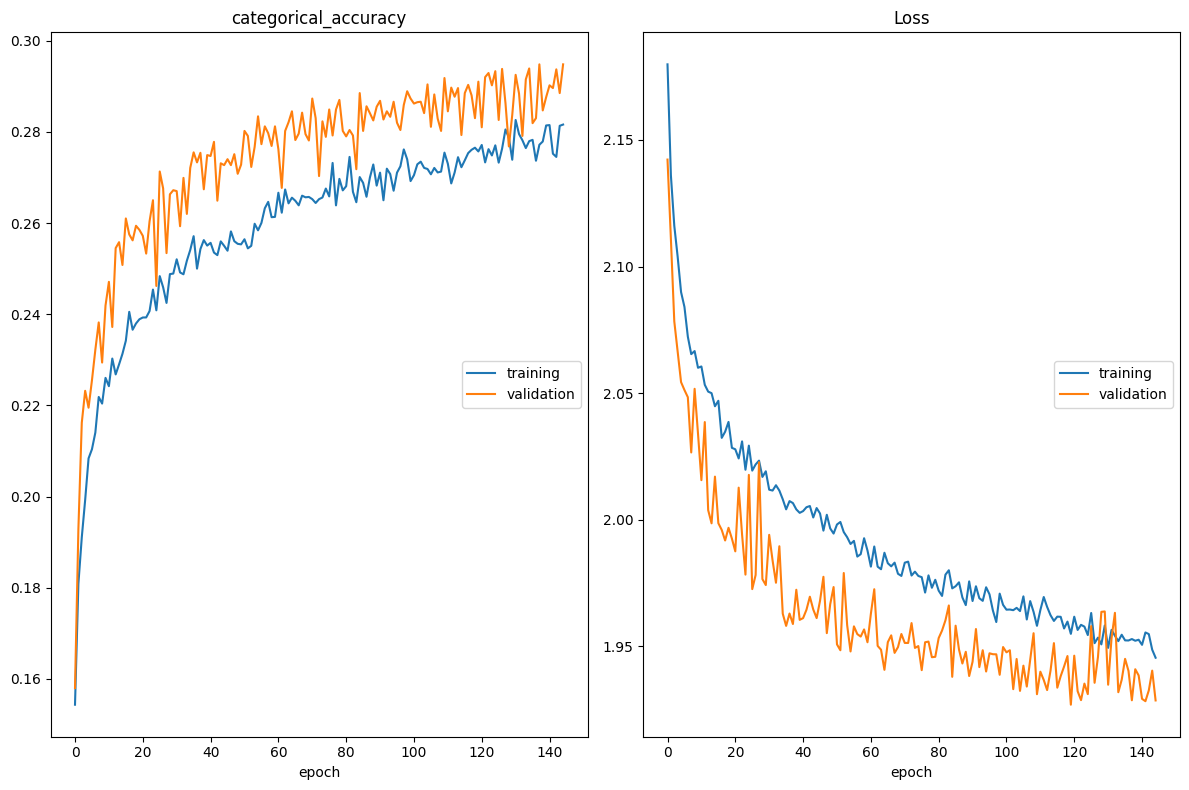

categorical_accuracy
	training         	 (min:    0.154, max:    0.283, cur:    0.282)
	validation       	 (min:    0.158, max:    0.295, cur:    0.295)
Loss
	training         	 (min:    1.945, max:    2.180, cur:    1.945)
	validation       	 (min:    1.927, max:    2.142, cur:    1.929)

Epoch 145: val_loss did not improve from 1.92691
Restoring model weights from the end of the best epoch: 120.
250/250 [==============================] - 142s 566ms/step - loss: 1.9455 - categorical_accuracy: 0.2816 - val_loss: 1.9286 - val_categorical_accuracy: 0.2948
Epoch 145: early stopping
CPU times: user 6h 30min 4s, sys: 2h 24min 13s, total: 8h 54min 18s
Wall time: 5h 44min 39s


In [15]:
%%time

EPOCHS = 500
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=250,
    validation_steps=100,
    validation_data=validation_generator,
    callbacks=[plot_progress, loss_checkpoint, stopper],
    verbose = True)

In [16]:
#Проверка текущих результатов:
model.evaluate(validation_generator)

101/101 [==============================] - 25s 241ms/step - loss: 1.9269 - categorical_accuracy: 0.2910


[1.9269227981567383, 0.2909963130950928]

Детальнее посмотрим на результаты нашей модели. Начнем с того, что выведем предсказание по случайному батчу из валидационного сета:

In [17]:
#Для этого напишем функцию, выведем несколько изображений и их предсказания, а также правильные ярлыки на экран:
def show_images_preds(images, labels, predicted_labels=None):
    names = dict((v,k) for k,v in train_generator.class_indices.items()) #подтянем названия классов по их нумерации в датагене
    plt.figure(figsize=(12,12))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    #Выведем 9 изображений по 3 в каждом ряду:
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i]
        #Нормализация цвета для текущего изображения:
        img = ((img-img.min()) / (img.max()- img.min())) * 255
        img = Image.fromarray(img.astype(np.uint8))
        plt.imshow(img)
        #Настройка отображения ярлыков
        if predicted_labels is not None:
            real_label = labels[i].argmax()
            title_obj = plt.title(f"Real: {names[real_label]}. Pred: {names[predicted_labels[i]]}")
            #Если предсказанный ярлык не совпадает с фактическим, цвет текста поменяем на красный:
            if real_label != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

4/4 [==============================] - 0s 139ms/step


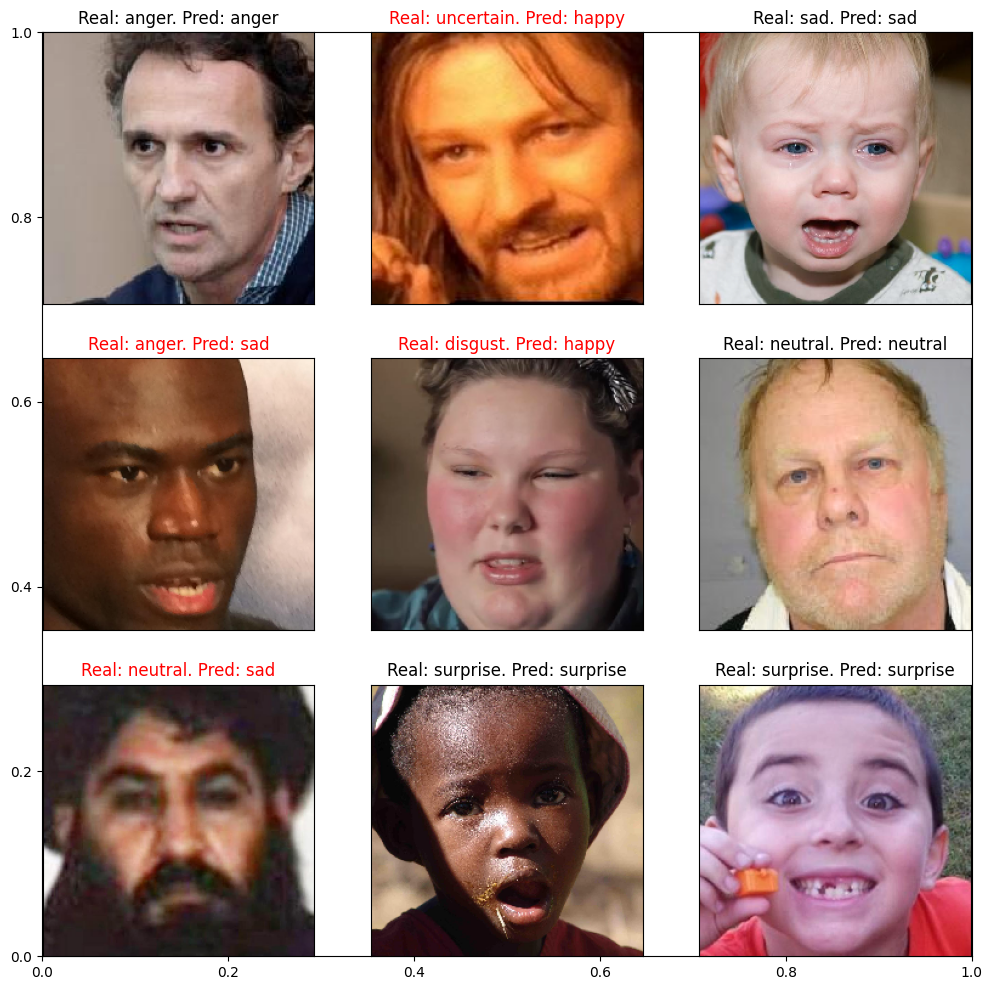

In [32]:
#Опробуем на случайном батче
sample_validation_images, sample_validation_labels = validation_generator[10]
predicted = model.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

In [34]:
# Также выведем так называемую матрицу ошибок, чтобы детальнее оценить масштабы бедствия/успеха:
preds = model.predict(validation_generator)
y_pred = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)

101/101 [==============================] - 25s 244ms/step


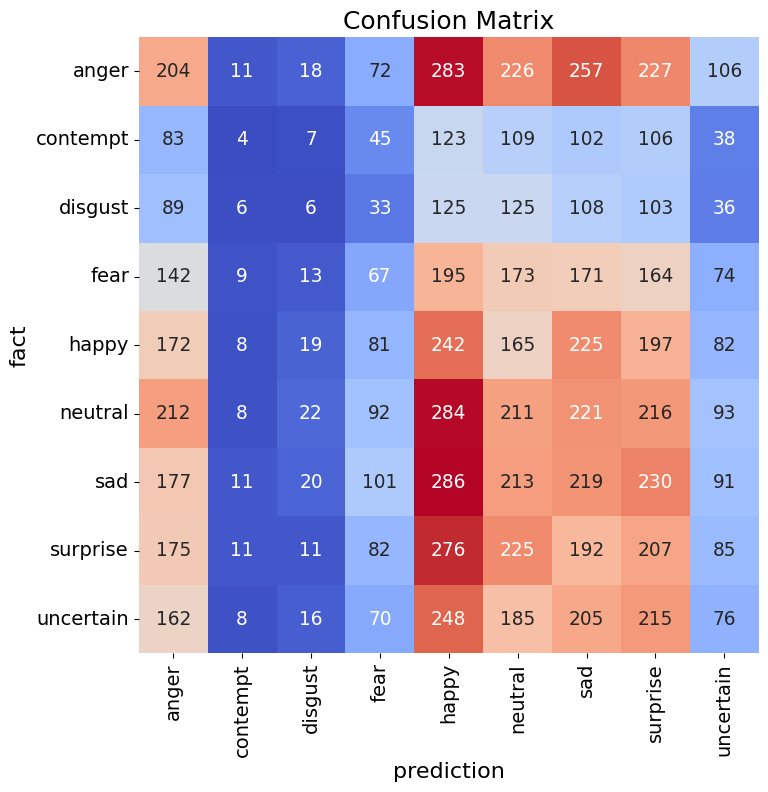

In [37]:
#Функция для отображения матрицы ошибок
def show_conf_matrix(y_test, y_pred, subset=None, cmap = "coolwarm", figsize = (8,8)):
    if subset is not None:
        cm_data = confusion_matrix(y_test , y_pred, labels=subset)
        names = dict((v,k) for k,v in train_generator.class_indices.items())
        cm_labels = [names[i] for i in subset]
    else:
        cm_labels = list(train_generator.class_indices.keys())
        cm_data = confusion_matrix(y_test , y_pred)
    
    cm = pd.DataFrame(cm_data, columns=cm_labels, index = cm_labels)
    cm.index.name = 'fact'
    cm.columns.name = 'prediction'
    plt.figure(figsize = figsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('fact', fontsize=16)
    plt.ylabel('prediction', fontsize=16)
    plt.title('Confusion Matrix', fontsize = 18)
    ax = sns.heatmap(cm, cbar=False, cmap = cmap, annot=True, fmt='g', cbar_kws={'label': 'Scale'}, annot_kws={"size":40 / np.sqrt(len(cm))})
    
show_conf_matrix(y_test, y_pred)

In [38]:
#Наконец, посмотрим на classification report по модели:
names = list(train_generator.class_indices.keys())
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.14      0.15      0.14      1404
    contempt       0.05      0.01      0.01       617
     disgust       0.05      0.01      0.02       631
        fear       0.10      0.07      0.08      1008
       happy       0.12      0.20      0.15      1191
     neutral       0.13      0.16      0.14      1359
         sad       0.13      0.16      0.14      1348
    surprise       0.12      0.16      0.14      1264
   uncertain       0.11      0.06      0.08      1185

    accuracy                           0.12     10007
   macro avg       0.11      0.11      0.10     10007
weighted avg       0.11      0.12      0.11     10007



In [39]:
#Далее, посмотрим на все слои базовой модели resnet, чтобы понять с какого слоя следует начать дообучение:
for i,layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [40]:
# Разморозим последние 2 conv блока в нашей модели (слой 166 и дальше):
for layer in model.layers[0].layers[:166]:
    layer.trainable = False
for layer in model.layers[0].layers[166:]:
    layer.trainable = True

In [41]:
# Проверка статуса:
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

### Fine tuning

Прошерстив немного литературы, я пришла к выводу, что имеет смысл дообучить нашу модель с учетом другой метрики - f1-score, т.к. она учитывает сразу precision и recall, а также чаще рекомендуется для задач классификации в целом и для задач классификации несбалансированных наборов данных в частности.

F1 score в качестве метрики для мониторинга оказалось не совсем просто реализовать на практике.

Для этого пришлось скачивать старую библиотеку tensorflow_addons, чтобы модель не ругалась на форму ввода.

Другие варианты решения проблемы предполагали самостоятельную реализацию функции для данной метрики, что мне показалось не совсем разумным, учитывая что существует вполне себе рабочий вариант.

Для работы метрики с множественной (небинарной) классификацией необходимо, помимо прочего, указать метод усреднения показателей. Мы укажем метод качестве такого метода "weighted" -функция вычисляет f1 для каждой метки класса и возвращает среднее значение с учетом доли каждого класса в наборе данных (или так называемой "поддержки" класса, англ. - "support").

Примечание: Усреднение "macro" (простое взвешенное), к сожалению, показывает чуть менее удачные результаты по итогам обучения, при том, что именно такую методику в первую очередь рекомендуют для несбалансированных датасетов, в которых классы равнозначны по важности. Проверено на практике.

In [43]:
import tensorflow_addons as tfa
#Для учета несбалансированности датасета укажим параметр weighted (см.выше).
f1 =tfa.metrics.F1Score(num_classes=9, average='weighted')

/home/nette/miniconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 




In [46]:
initial_learning_rate = 0.0005
final_learning_rate = 0.00005

# Lr будем уменьшать в соответствии с значением f1-score
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.9, patience=25, verbose=1, min_lr=final_learning_rate)
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

*Примечание: было интересно посмотреть, какие результаты покажет модель в зависимости от метрики, на которую она ориентируется при сохранении результатов обучения, поэтому я решила сделать сразу 3 чекпойнта - по одному на каждую метрику.*

In [48]:
model.compile(optimizer=opt,
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(), f1])

#Чекпойнты:
plot_progress = PlotLossesCallback()
l_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/new_model/ft_2blocks_loss.h5',monitor="val_loss",verbose=1, save_best_only=True, mode="min")
acc_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/new_model/ft_2blocks_acc.h5',monitor="val_categorical_accuracy",verbose=1, save_best_only=True, mode="max")
f1_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/new_model/ft_2blocks_f1.h5',monitor="val_f1_score",verbose=1, save_best_only=True, mode="max")
stopper = EarlyStopping(monitor = 'val_loss', verbose = 1, restore_best_weights=True, mode="min", patience = 25)

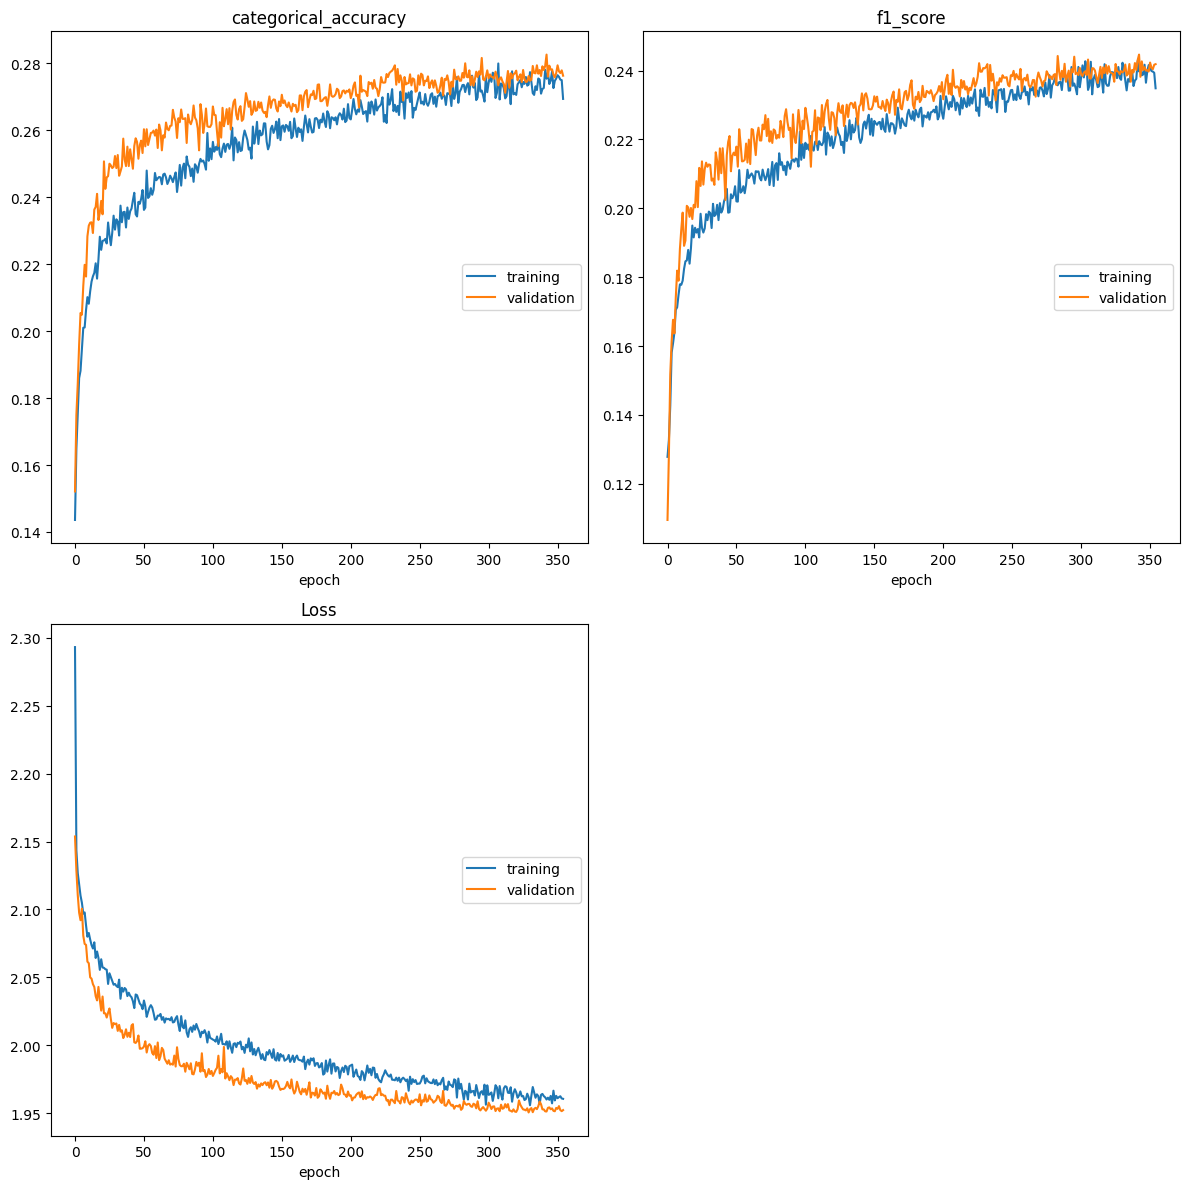

categorical_accuracy
	training         	 (min:    0.144, max:    0.280, cur:    0.269)
	validation       	 (min:    0.152, max:    0.283, cur:    0.276)
f1_score
	training         	 (min:    0.128, max:    0.243, cur:    0.235)
	validation       	 (min:    0.109, max:    0.245, cur:    0.242)
Loss
	training         	 (min:    1.956, max:    2.293, cur:    1.961)
	validation       	 (min:    1.951, max:    2.154, cur:    1.952)

Epoch 355: val_categorical_accuracy did not improve from 0.28260

Epoch 355: val_f1_score did not improve from 0.24464

Epoch 355: val_loss did not improve from 1.95058
Restoring model weights from the end of the best epoch: 330.
250/250 [==============================] - 141s 564ms/step - loss: 1.9606 - categorical_accuracy: 0.2694 - f1_score: 0.2349 - val_loss: 1.9523 - val_categorical_accuracy: 0.2763 - val_f1_score: 0.2419 - lr: 1.1438e-04
Epoch 355: early stopping
CPU times: user 15h 55min 31s, sys: 5h 53min 26s, total: 21h 48min 58s
Wall time: 14h 4min 18s

In [49]:
%%time


ft_history = model.fit_generator(
    train_generator,
    epochs=500,
    steps_per_epoch=250,
    validation_steps=100,
    validation_data=validation_generator,
    callbacks=[plot_progress, acc_checkpoint, f1_checkpoint, l_checkpoint, stopper, reduce_lr],
    verbose = True)

В итоге другая версия модели выдавала результаты лучше, так что от этой идеи пришлось отказаться...